In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="darkgrid", palette = 'Set2')

# Fraud analysis and detection

Exploratory data analysis of the transaction dataset provided by CloudWalk for evaluation of the Payment Analyst role

### Loading and observations of the obtained data

In [76]:
dados = pd.read_csv('transactional-sample.csv')
dados.columns

Index(['transaction_id', 'merchant_id', 'user_id', 'card_number',
       'transaction_date', 'transaction_amount', 'device_id', 'has_cbk'],
      dtype='object')

About the columns of our dataset:

transaction_id: transaction identification number

merchant_id: merchant identification number

user_id: user id number

card_number: credit card number that made the purchase (partial)

transaction_date: transaction date

transaction_amount: transaction amount

device_id: identification number of the device on which the transaction was performed

has_cbk: flag of whether the chargeback occurred or not

In [77]:
dados.head(3)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False


In [78]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


In [79]:
dados.isna().sum()

transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

In [80]:
dados.duplicated().sum()

0

* The presented dataset has 3199 lines. 
* 'device_id' is the only feature that has missing values
* The transaction_date column is not the proper dtype
* No duplicated values

In [81]:
# Adjusting dtype of transaction_date
dados['transaction_date'] = pd.to_datetime(dados['transaction_date'])


## Hypotheses to be followed:
1- Suspicious purchases are related to values

2- Suspicious purchases in relation to the period

3- Suspicious purchases are related to the User/Card/Merchant frequency



In [82]:
# Separating dataframe using has_cbk status
cbk_true = len(dados.loc[dados['has_cbk'] == True])
cbk_false = len(dados.loc[dados['has_cbk'] == False])
print('We have {}% of transations labbeled as chargeback happend'.format(round(100*cbk_true / len(dados),2)))

We have 12.22% of transations labbeled as chargeback happend


In [83]:
dados.groupby(['has_cbk'])['transaction_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
has_cbk,,,,,,,,
False,2808.0,672.324380,797.463853,1.22,191.285,360.315,812.5775,4091.83
True,391.0,1453.571918,1169.491346,2.89,565.580,999.470,2140.6800,4097.21


### 1- transaction_amount x has_cbk

Text(0.5, 1.0, 'Histplot of chargebacks')

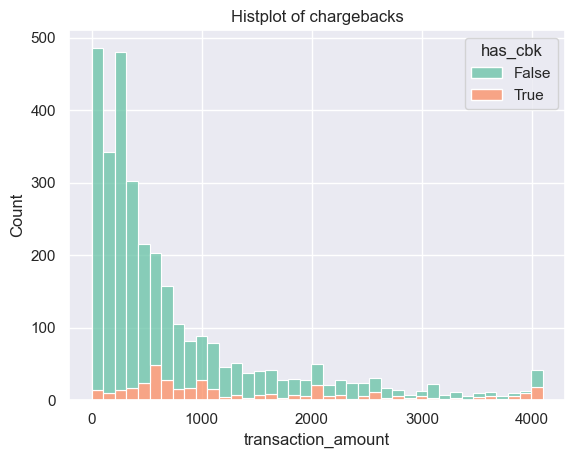

In [84]:
sns.histplot(data = dados, x ='transaction_amount', hue = 'has_cbk', multiple = 'stack')
plt.title("Histplot of chargebacks")

Text(0.5, 1.0, 'Boxplot of chargebacks')

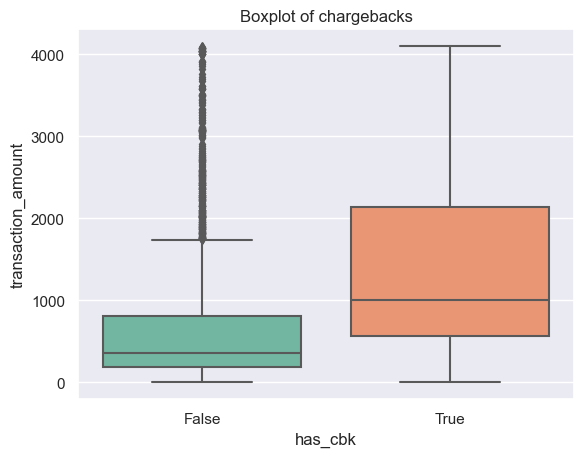

In [85]:
sns.boxplot(data = dados, y ='transaction_amount', x = 'has_cbk')
plt.title("Boxplot of chargebacks")

When viewing all transactions
and performing the boxplot it is notable that the first quartile of transactions where has_cbk is True is above the median transactions has_cbk False



Text(0.5, 1.0, 'Boxplot with user_id with history of chargebacks')

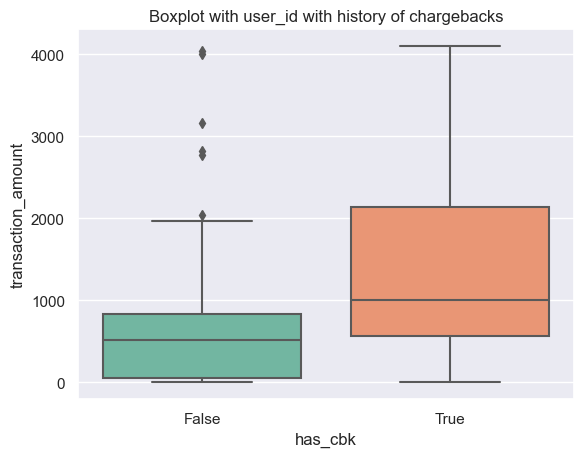

In [86]:
# Generating a dataframe with only all user transactions that have already had chargeback
lista_user_cbk = dados.loc[dados['has_cbk'] == True]['user_id']
dados_so_user_cbk = dados.loc[dados['user_id'].isin(lista_user_cbk)]

sns.boxplot(data = dados_so_user_cbk, y ='transaction_amount', x = 'has_cbk')
plt.title("Boxplot with user_id with history of chargebacks")


When we isolate the user_id that have a history of has_cbk True, the boxplot pattern is maintained. We can see that the average chargeback transactions are higher. We have chargeback across the range of values, but we have to focus and be aware of transactions above historical averages

### 2 - transaction_date x has_cbk

#### By time period

Text(0.5, 1.0, 'Scatterplot of chargebacks')

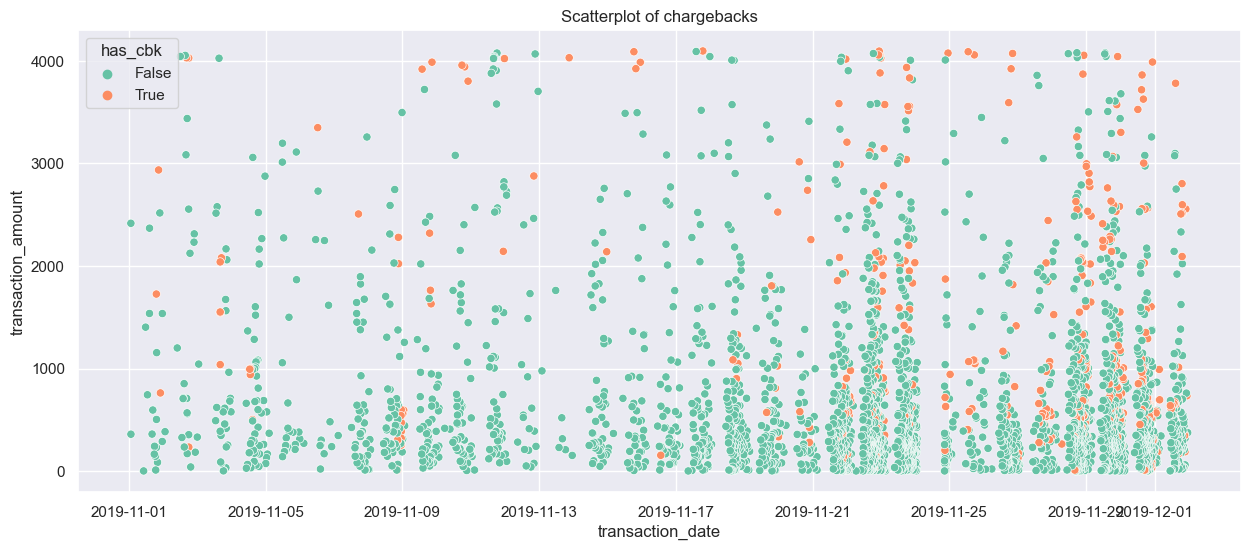

In [87]:
plt.figure(figsize=(15, 6))
sns.scatterplot(data = dados, y ='transaction_amount', x = 'transaction_date', hue = 'has_cbk')
plt.title("Scatterplot of chargebacks")

We noticed a large concentration of transactions in the last week of November, due to BlackFriday

In [88]:
# Generating a dataframe with only the transactions of the last week of November
dados_selecionado_periodo = dados.loc[dados['transaction_date'] > pd.to_datetime('2019-11-24')]

# Group transactions by has_cbk status
resumo_por_dia_cbk = dados_selecionado_periodo.groupby([dados_selecionado_periodo['transaction_date'].dt.date, 'has_cbk'])['transaction_amount'].count()
total_por_dia = resumo_por_dia_cbk.groupby('transaction_date').sum()
percentual_por_dia_cbk = resumo_por_dia_cbk / total_por_dia * 100

print('Breakdown by day, of the classification of transactions - Percentage Values')
print(round(percentual_por_dia_cbk,2))

Breakdown by day, of the classification of transactions - Percentage Values
transaction_date  has_cbk
2019-11-24        False      91.67
                  True        8.33
2019-11-25        False      79.17
                  True       20.83
2019-11-26        False      91.30
                  True        8.70
2019-11-27        False      69.88
                  True       30.12
2019-11-28        False      85.37
                  True       14.63
2019-11-29        False      82.30
                  True       17.70
2019-11-30        False      80.99
                  True       19.01
2019-12-01        False      82.24
                  True       17.76
Name: transaction_amount, dtype: float64


In [89]:
# Group all transactions by day
resumo_por_dia = dados_selecionado_periodo.groupby([dados_selecionado_periodo['transaction_date'].dt.date])['transaction_amount'].count()
percentual_por_dia = resumo_por_dia / len(dados) * 100
print('Percentage of transactions per day vs total for the period')
print(percentual_por_dia)


Percentage of transactions per day vs total for the period
transaction_date
2019-11-24     1.875586
2019-11-25     1.500469
2019-11-26     3.594873
2019-11-27     2.594561
2019-11-28     8.971554
2019-11-29    10.065646
2019-11-30     8.877774
2019-12-01     4.751485
Name: transaction_amount, dtype: float64


In [90]:
print('Total of transactions during 2019-11-24 to 2019-12-01 is equal to {}% of total'.format(round(percentual_por_dia.sum(),2)))
cbk_true_bf = len(dados_selecionado_periodo.loc[dados_selecionado_periodo['has_cbk'] == True])
print('Considering transactions for the entire period, within 8 days we have {}% of transations labbeled as chargeback True'.format(round(100*cbk_true_bf / cbk_true,2)))


Total of transactions during 2019-11-24 to 2019-12-01 is equal to 42.23% of total
Considering transactions for the entire period, within 8 days we have 58.82% of transations labbeled as chargeback True


As is widely known, the last week of November is marked by the long-awaited Black Friday season, when retailers offer a variety of attractive promotions.

By analyzing our dataframe, we can see a significant increase in the number of transactions during this period, which was expected due to the high demand generated by the promotions. However, it is important to highlight that we also see a considerable increase in chargeback cases, where customers dispute transactions and request a refund. This above-average incidence of chargebacks during Black Friday is a critical aspect that deserves our attention.

#### By hour

In [91]:
# Creating a column to work with hours
dados['hora'] = dados['transaction_date'].dt.hour

# Group by time and count distribution of True values ​​in has_cbk
distribuicao_por_hora = dados.groupby('hora')['has_cbk'].value_counts(normalize=True).mul(100).unstack()
distribuicao_por_hora


has_cbk,False,True
hora,,
0,81.954887,18.045113
1,87.387387,12.612613
2,70.491803,29.508197
3,86.666667,13.333333
4,100.000000,NaN
5,100.000000,NaN
6,50.000000,50.000000
8,100.000000,NaN
9,100.000000,NaN


From 7 pm to 3 am is the main period for chargebacks.

### By days

In [92]:
# Extract the day of the week
dados['dia_semana'] = dados['transaction_date'].dt.dayofweek

# Map weekday number to day name
nome_dia_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
dados['nome_dia_semana'] = dados['dia_semana'].map(lambda x: nome_dia_semana[x])

# Group by day of the week and count distribution of True values ​​in has_cbk
distribuicao_por_dia_semana = dados.groupby('nome_dia_semana')['has_cbk'].value_counts(normalize=True).mul(100).unstack()

# Reindex the DataFrame
distribuicao_por_dia_semana = distribuicao_por_dia_semana.reindex(nome_dia_semana)

print(distribuicao_por_dia_semana)

has_cbk              False      True 
nome_dia_semana                      
Segunda-feira    92.957746   7.042254
Terça-feira      93.750000   6.250000
Quarta-feira     78.343949  21.656051
Quinta-feira     88.888889  11.111111
Sexta-feira      85.093168  14.906832
Sábado           86.904762  13.095238
Domingo          89.540816  10.459184


Wednesday to Saturday are the main days to stay tuned

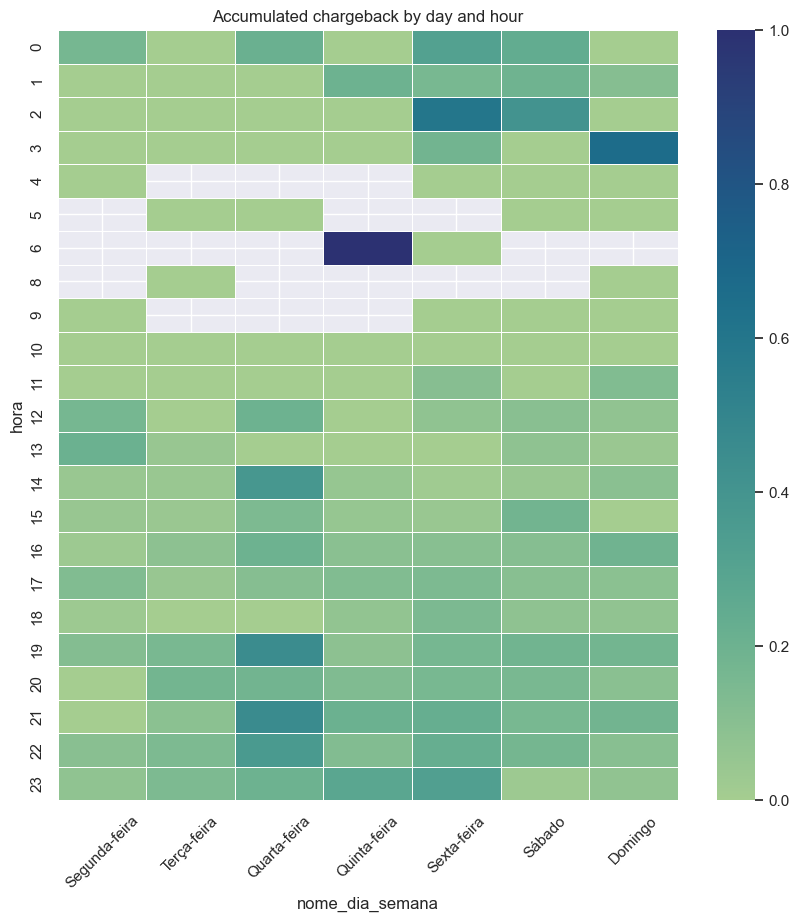

In [93]:
# Calculate the percent distribution of True values ​​in has_cbk by day of week and time
distribuicao_conjunta = dados.pivot_table(index='nome_dia_semana', columns='hora', values='has_cbk')
distribuicao_conjunta = distribuicao_conjunta.reindex(nome_dia_semana)


# Ajust and plot
plt.figure(figsize=(10, 10))
sns.heatmap(distribuicao_conjunta.T, linewidth=.5, cmap="crest")
plt.title("Accumulated chargeback by day and hour")
plt.xticks(rotation=45)
plt.show()


If the dataset were larger, it would be possible to assemble a heat map and evaluate the shifts where the chargeback occurrence is more intense, thus better allocating resources for problem resolution

### 3 - merchant_id, user_id, device_id and card_number x has_cbk

In [94]:
# A view of the top 20 transactions sorted by user_id
has_cbk_True = dados.loc[dados['has_cbk'] == True].sort_values(by = ['user_id'])
has_cbk_True.head(20)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,hora,dia_semana,nome_dia_semana
1800,21322198,53041,900,412177******1138,2019-11-22 19:15:41.109970,1346.26,691601.0,True,19,4,Sexta-feira
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105.0,True,22,6,Domingo
142,21320540,62194,3157,535081******2584,2019-12-01 01:50:22.799457,183.73,586347.0,True,1,6,Domingo
1050,21321448,55854,3584,544731******9913,2019-11-27 23:20:08.418774,542.36,707086.0,True,23,2,Quarta-feira
1068,21321466,55854,3584,544731******7164,2019-11-27 20:03:18.903863,607.96,707086.0,True,20,2,Quarta-feira
1074,21321472,55854,3584,544731******7164,2019-11-27 19:27:18.390049,529.19,707086.0,True,19,2,Quarta-feira
1069,21321467,55854,3584,544731******7164,2019-11-27 19:56:17.352455,971.97,707086.0,True,19,2,Quarta-feira
545,21320943,63050,4651,606282******4880,2019-11-29 18:34:37.726351,3068.63,571150.0,True,18,4,Sexta-feira
1718,21322116,38337,4651,230744******4802,2019-11-22 22:31:51.568374,2090.41,571150.0,True,22,4,Sexta-feira
1714,21322112,38337,4651,230744******4802,2019-11-22 22:41:36.534791,1019.39,571150.0,True,22,4,Sexta-feira


The first impression is that we have several users trying to carry out several transactions, with similar merchant_id and device_id but not necessarily on the same day or in a close time

In [95]:
# Evaluating how many devices were used by 1 or more people
device_counts = has_cbk_True['device_id'].value_counts()
device_com_um_usuario = device_counts[device_counts == 1]
device_com_mais_usuarios = device_counts[device_counts != 1]

merchant_counts = has_cbk_True['merchant_id'].value_counts()
merchant_com_um_usuario = merchant_counts[merchant_counts == 1]
merchant_com_mais_usuarios = merchant_counts[merchant_counts != 1]

print('We have {} devices_id with one user_id and {} with more then one user_id'.format(len(device_com_um_usuario),len(device_com_mais_usuarios) ))
print('We have {} merchant_id with one user_id and {} with more then one user_id'.format(len(merchant_com_um_usuario),len(merchant_com_mais_usuarios) ))

We have 63 devices_id with one user_id and 66 with more then one user_id
We have 52 merchant_id with one user_id and 66 with more then one user_id


When evaluating the relationship between merchant id and device id with user_id, we do not have a 1-1 connection, so I believe that it is better for us to evaluate the entities with the highest amount of chargeback.

As we have few transactions and a lot of missing devices_id, we will not continue with the analysis of this feature.

In [96]:
# Evaluating user_id with the highest amount of chargeback
resumo_user_id= has_cbk_True.groupby(['user_id'])['has_cbk'].count()
resumo_user_id.sort_values(ascending = False).head(10)

user_id
11750    25
91637    19
79054    15
96025    13
78262    12
75710    10
7725      7
21768     6
17929     6
71424     5
Name: has_cbk, dtype: int64

In [97]:
# Evaluating merchant_id with the highest amount of chargeback
resumo_merchant_id = has_cbk_True.groupby(['merchant_id'])['has_cbk'].count()
resumo_merchant_id.sort_values(ascending = False).head(10)

merchant_id
17275    22
4705     19
1308     15
53041    14
77130    13
44927    11
91972    11
73271    10
55854     9
29214     9
Name: has_cbk, dtype: int64

In [98]:
# Generating a table with the offending user_id and the unique amount of cards and establishments used
tabela_user_ofensora = has_cbk_True.groupby('user_id')[['transaction_id','card_number','merchant_id']].nunique()
tabela_user_ofensora.rename(columns = {'transaction_id' : 'Transaction count',
                                     'merchant_id':'merchant count',
                                     'card_number':'card count'}, inplace = True)
tabela_user_ofensora.sort_values(by = 'Transaction count', ascending = False).head(10)


,Transaction count,card count,merchant count
user_id,,,
11750,25,25,2
91637,19,19,1
79054,15,13,4
96025,13,9,2
78262,12,9,3
75710,10,1,1
7725,7,5,1
21768,6,1,2
17929,6,6,2


Users_id that do many transactions with several cards in few merchant_ids

In [99]:
# Generating a table with the offending merchant_id and the unique amount of cards and user_id
tabela_merchant_ofensora = has_cbk_True.groupby('merchant_id')[['transaction_id','card_number','user_id']].nunique()
tabela_merchant_ofensora.rename(columns={'transaction_id' : 'Transaction count',
                                     'user_id':'user count',
                                     'card_number':'card count'}, inplace = True)
tabela_merchant_ofensora.sort_values(by = 'Transaction count', ascending = False).head(10)


,Transaction count,card count,user count
merchant_id,,,
17275,22,22,2
4705,19,19,1
1308,15,8,2
53041,14,8,6
77130,13,2,2
44927,11,4,3
91972,11,11,9
73271,10,8,3
55854,9,4,3


Merchant_ids that have sales paid with several cards in few users_id

In [100]:
# Generating a table with the offending card_number and the unique amount of merchant_id and user_id
tabela_card_ofensora = has_cbk_True.groupby('card_number')[['transaction_id','merchant_id','user_id']].nunique()
tabela_card_ofensora.rename(columns={'transaction_id' : 'Transaction count',
                                     'user_id':'user count',
                                     'merchant_id':'merchant count'}, inplace = True)
#print(tabela_card_ofensora.sort_values(by = 'Transaction count', ascending = False)['user count'].unique())
tabela_card_ofensora.sort_values(by = 'Transaction count', ascending = False).head(10)


,Transaction count,merchant count,user count
card_number,,,
554482******7640,10,1,1
530034******3859,6,2,1
651653******2256,5,1,1
552289******8870,4,1,1
530034******8258,4,1,1
498406******7104,4,1,1
459080******2870,4,1,1
441030******2146,4,1,1
550209******3098,3,1,1


Same cards used in multiples transactions by 1 or 2 people only and few merchant_id

# Conclusions

Although we are dealing with a dataset with a small sample of an atypical month with the Black Friday event, we have the following observations:

* Be aware of transactions above historical averages;
* There is a critical time range for transactions with the highest amount of chargebacks, it would be from 7 pm to 3 am;
* Purchases made from Tuesday to Saturday have a higher probability of chargeback;
* Regarding suspicious behavior, we can point out users who carry out several transactions with different cards in a few merchants;
* Finally, the amount of chargebacks during black friday is noted, therefore, it is essential that companies are prepared to deal with this time of high demand and take proactive measures to minimize the risk of chargebacks, ensuring a positive experience for customers and preserving the financial integrity of the business.



# In addition to the spreadsheet data, what other data would you look at to try to find patterns of possible frauds?

Location: You can consider the geographic location of the transaction based on the IP address of the device used for the transaction or the physical location of the face-to-face transaction, such as the address of the store or commercial establishment where the purchase was made.

Authentication Data: Verify that the transaction was authenticated using additional authentication such as a password, authentication code sent via SMS, or two-step authentication.

Device analytics: Analyze device usage patterns, such as the number of devices used by a user, frequent device changes, or device usage that is unusual for the user.

Credit Card Verification: In addition to the partial credit card number, you can verify the card type (Visa, Mastercard, American Express, etc.), expiration date, and whether the card is registered as stolen or lost.

# Considering your conclusions, what could you do to prevent frauds and/or chargebacks?

Monitor high-risk transactions: Focus on monitoring and reviewing transactions that fall within the critical time frame identified as having the highest number of chargebacks. Allocate resources to closely monitor and analyze transactions during this period to quickly identify and resolve any potential fraudulent activity.

Educate Customers: Provide customers with clear information about transaction processes, security measures, and steps they can take to protect their accounts. Educate them on the importance of keeping their login credentials secure by regularly monitoring their transaction history and reporting any suspicious activity immediately.

Enhanced authentication methods: Implement strong authentication methods, such as multi-factor authentication (MFA), to verify users' identities during transactions. This can include the use of SMS verification codes, biometric authentication, or token-based authentication. 

Preparing for busy holidays: As noted, Black Friday carries a higher risk of chargebacks. Take proactive steps to prepare for this period, such as increasing fraud prevention efforts, improving customer support, and closely monitoring transactions during this high-demand period.

# How would you monitor identified patterns?

To monitor identified patterns, you can implement a combination of manual and automated monitoring methods.

Real-time transaction monitoring: Utilizes real-time monitoring systems that analyze transaction data as it occurs.

Threshold monitoring: Set specific thresholds or rules based on identified patterns or suspicious behavior

Anomaly Detection: Employing anomaly detection techniques to identify transactions that deviate significantly from expected patterns or patterns

Customer Behavior Analysis: Analyze customer behavior over time to establish baseline patterns and identify deviations from normal behavior.

Manual review and investigation: Allocate resources to perform manual review and investigation based on flagged or suspicious transactions.
 
Periodic Data Analysis: Performs regular data analysis to identify long-term trends and patterns in activity activities.